In [68]:
import deconV as dv
from deconV import DeconV
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px
import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
reference_file = "../../data/xin/sc.tsv"
reference_mdata_file = "../../data/xin/pdata.tsv"
bulk_file = "../../data/xin/bulk.tsv"
cell_types = ["alpha", "delta", "gamma", "beta"]
true_df = pd.read_csv("../../data/xin/true.tsv", sep="\t", index_col=0)

In [70]:
sadata = dv.tl.read_data(reference_file)

pheno_df = pd.read_csv(reference_mdata_file, sep="\t", index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))

sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs["labels"] = pheno_df["cellType"].tolist()
sadata.obs["labels"] = sadata.obs["labels"].astype("category")

sadata = sadata[sadata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(sadata.obs.groupby("labels").size())

bulk_df = pd.read_csv(bulk_file, sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_counts=100)
adata = dv.tl.combine(sadata, bulk_df)
del sadata
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)
# sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)
adata.obsm["lib_size"] = adata.layers["counts"].sum(1)
adata.shape

labels
alpha    443
beta     171
delta     59
gamma     75
dtype: int64
bulk RNA-seq data - samples: 18, genes: 39849
scRNA-seq data - cells: 748, genes: 15029
bulk RNA-seq data - samples: 18, genes: 15029


(748, 15029)

In [71]:
sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

In [72]:
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["labels"], frameon=True, legend_loc="on data", save="_xin.pdf", title="")

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
# adata = adata[:, (np.equal(np.mod(adata.layers["counts"], 1), 0) == False).max(0) != True].copy()

In [88]:
decon = dv.DeconV(
    adata, cell_type_key="labels",
    dropout_type="separate",
    model_type="gamma", sub_type_key=None,
    device=device
)

In [89]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts", fp_hack=False)

Rounding counts to integers.


100%|██████████| 2000/2000 [00:35<00:00, 56.11it/s, loss=3.68e+05, lr=1.35e-02]


In [77]:
# decon.check_fit()

In [103]:
adata.var_names[idx[:69]]

Index(['TBCA', 'MRPL36', 'USO1', 'RYR1', 'ING3', 'MCM4', 'HNF4A', 'TCP11L1',
       'CMTM6', 'FAM19A4', 'RPS23', 'LOC101927560', 'RLIM', 'FMO4', 'PCDHB9',
       'CHRNA2', 'PHF3', 'AFTPH', 'CAPN13', 'TRIM13', 'SLC44A1', 'DUT',
       'PVRL3.AS1', 'STRN', 'LOC284648', 'PA2G4', 'ARL5A', 'MORC3', 'PSMD1',
       'AKAP8L', 'DCXR', 'MEMO1', 'LINC00877', 'TBC1D8', 'WNT5A', 'PLCXD3',
       'CXCL16', 'FOXJ3', 'HIATL1', 'KLHL26', 'MIR137HG', 'PICK1', 'DGCR8',
       'LOXL1.AS1', 'DAZAP1', 'GPAM', 'DTWD1', 'RMDN1', 'RSBN1', 'ATP5J2',
       'EMD', 'HIC2', 'PRKXP1', 'PIK3C2B', 'RAB3D', 'NFKBIB', 'IMPA2',
       'TTC39C', 'C16orf95', 'CNTROB', 'KDM6B', 'LOC100288974', 'SLC39A8',
       'COX6B1', 'ENPP1', 'SSBP3', 'FAHD1', 'CASQ1', 'TUFT1'],
      dtype='object')

69

In [94]:
proportions = decon.deconvolute(model_dropout=True, ignore_genes=ignore_genes, lrd=0.999, lr=0.1, num_epochs=1000)

torch.Size([15029, 4])
torch.Size([15029, 4])
torch.Size([15029, 4])


100%|██████████| 1000/1000 [00:04<00:00, 224.66it/s, loss=1.48e+08, lr=3.68e-02]


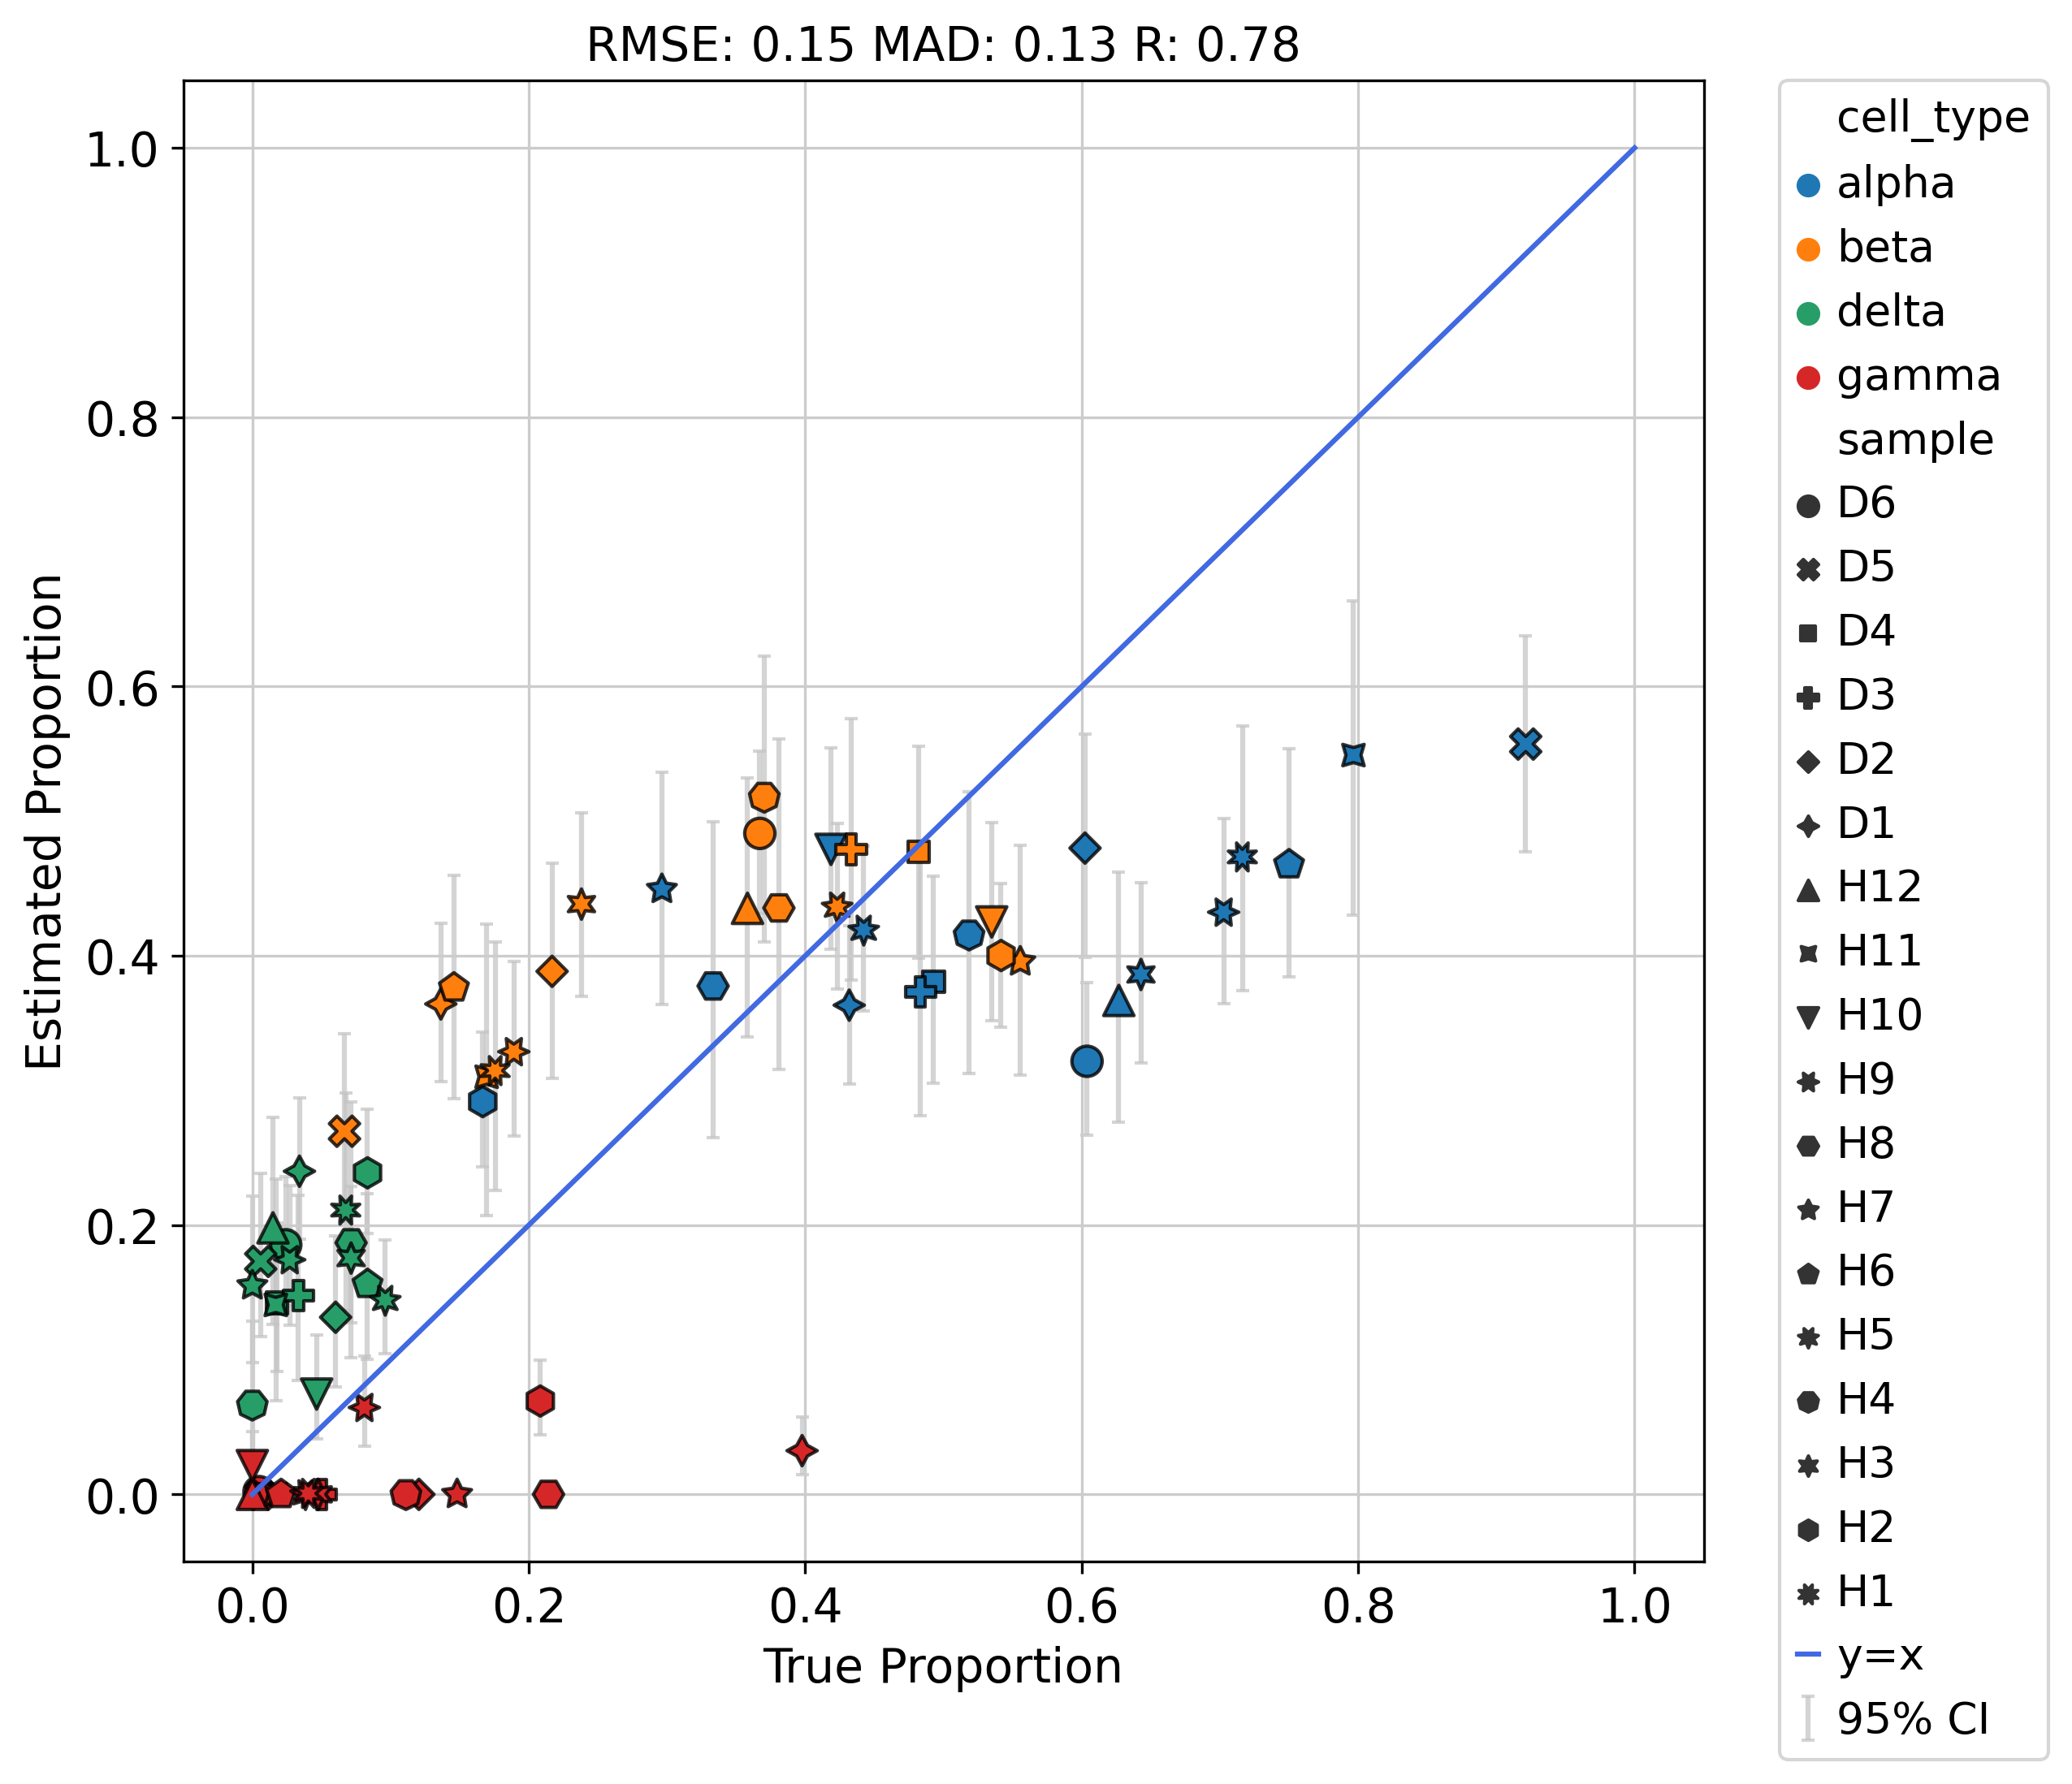

(0.15193872352685878, 0.1251562158879801, 0.7814428004741174)

In [95]:
res_df = decon.get_results_df()
res_df["true"] = true_df.melt()["value"]
dv.pl.xypredictions(res_df, figsize=(8,8), dpi=150)

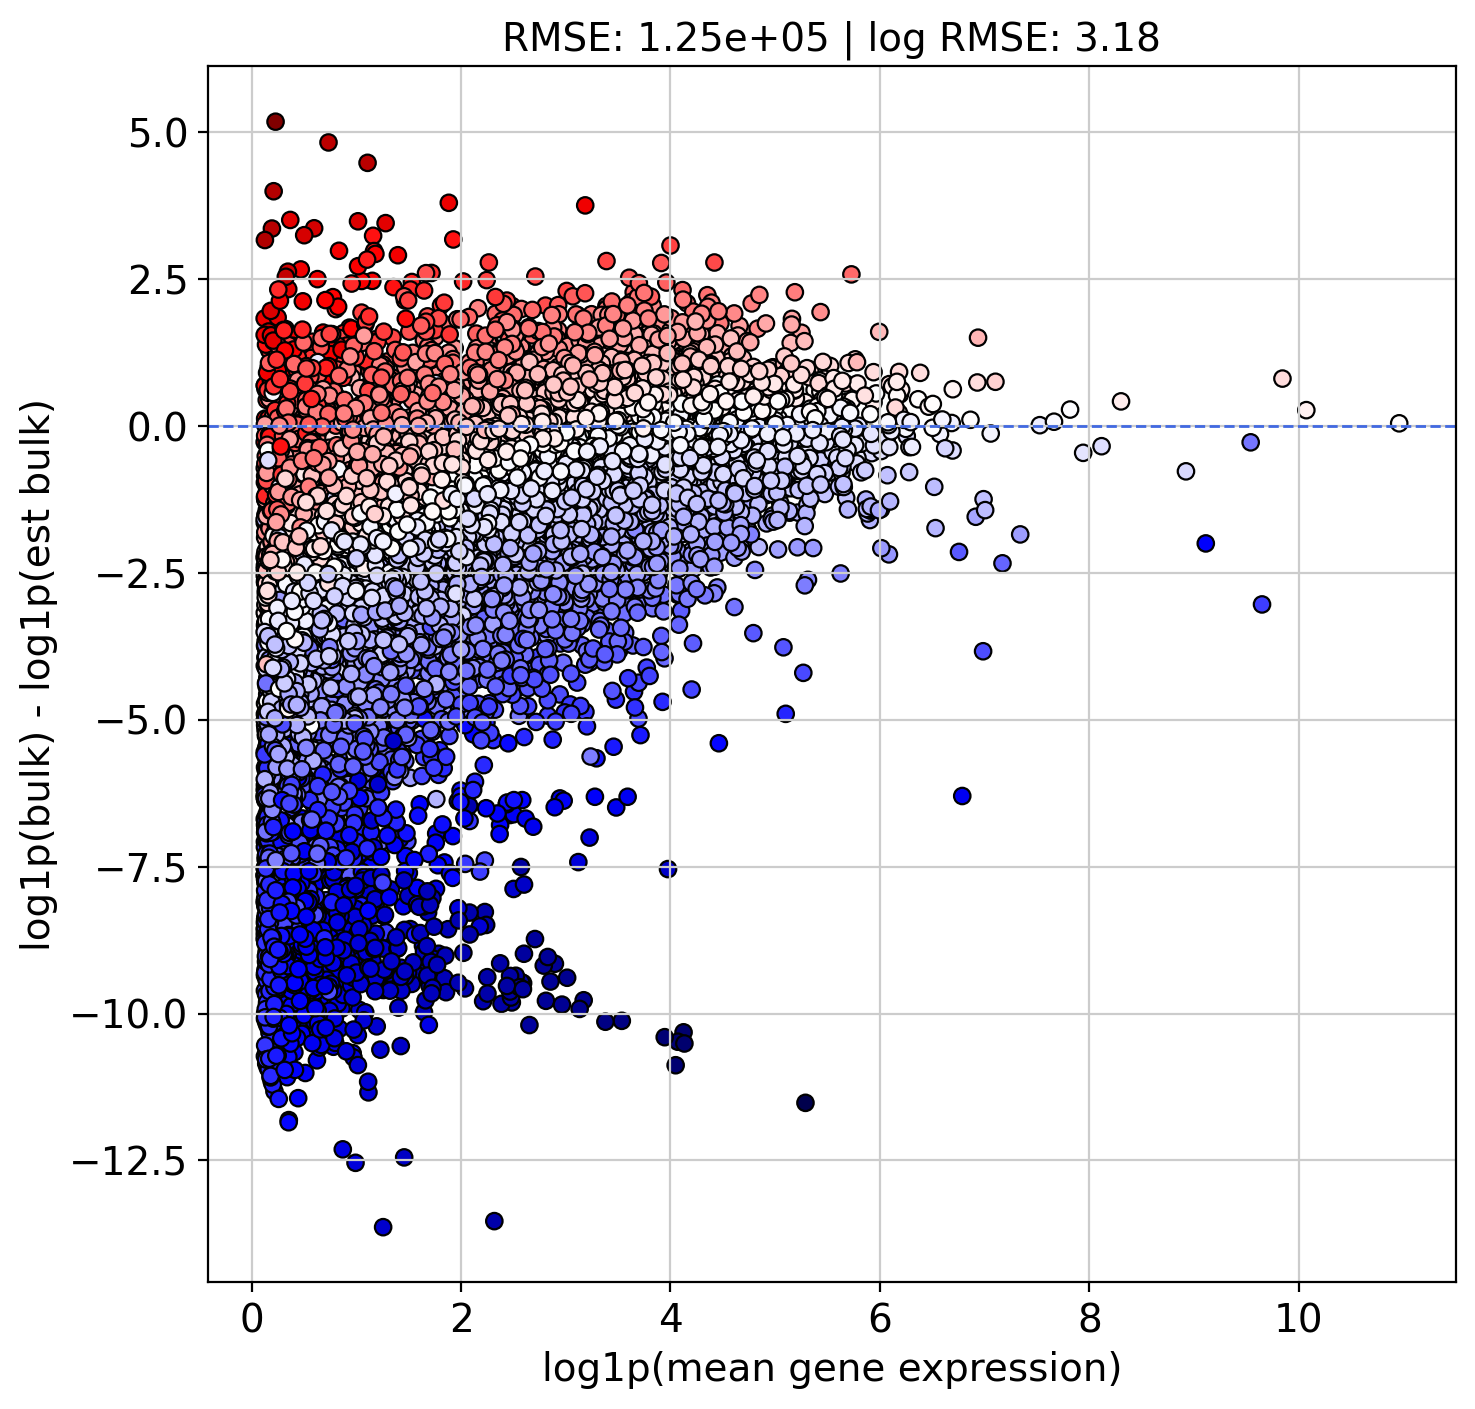

In [13]:
dv.pl.prediction_plot(decon, 1)

In [17]:
pd.DataFrame({
    "MuSiC": [0.10, 0.06, 0.94],
    "NNLS": [0.17, 0.12, 0.82],
    "BSEQ-sc": [0.21, 0.15, 0.79],
    "CIBERSORT": [0.21, 0.15, 0.76],
    "DeconV (Gamma)": [0.06, 0.04, 0.97]},
    index=["RMSD", "mAD", "R"]
)

,MuSiC,NNLS,BSEQ-sc,CIBERSORT,DeconV (Gamma)
RMSD,0.10,0.17,0.21,0.21,0.06
mAD,0.06,0.12,0.15,0.15,0.04
R,0.94,0.82,0.79,0.76,0.97
